In [1]:
'''

Assignment: QC-Mentorship Task #4

Author: Oscar Javier Hernandez

'''

from qiskit import *
import numpy as np

# Introduction

Our task will be to determine the lowest eigenvalue of the matrix $M$ using the variational quantum eigensolver method (VQE), where 

$
M = \begin{bmatrix}
0 & 0 & 0 & 0  \\
0 & -1 & 1 & 0 \\
0 & 1 & -1 & 0 \\
0 & 0 & 0 & 0
\end{bmatrix}.
$

Recall that the Pauli matrices are given by

$
\begin{align}
X = \begin{bmatrix}0 &1  \\ 1 &0 \end{bmatrix}, &  &
Y = \begin{bmatrix} 0 & -i \\ i & 0 \end{bmatrix}, & &
Z = \begin{bmatrix} 1 &0  \\ 0 &-1 \end{bmatrix}. 
\end{align}
$

For two qubits, we have the following vector representation


$
\begin{align}
\vec{v} = \begin{bmatrix} 
\alpha_1 \\
\alpha_2 \\
\alpha_3 \\
\alpha_4 
\end{bmatrix} 
= \alpha_1 \left|00 \right> + \alpha_2 \left|01 \right> +\alpha_3 \left|10 \right> +\alpha_4 \left| 1 1 \right> 
\end{align}
$

# Pauli Decomposition

First, we decompose the matrix $M$ into a sum of 2-qubit operators,

\begin{align}
M = a X_1 \otimes X_2+b Y_1 \otimes Y_2+ c Z_1 \otimes Z_2+d I_1 \otimes I_2
\end{align}

where the subscripts ${1,2}$ denote the specific quibit on which the operator acts, $\otimes$ denotes the tensor product, and $a,b,c,d$ are undertermined coefficients. We solve this decomposition using the matrix representation of the tensor product. To see what this representation looks like we define the $X,Y,Z$ pauli matrices in code below.

In [2]:
# Define the Pauli matrices 

X = np.array([[0,1],[1,0]])
Y = np.array([[0,-np.complex(0,1)],[np.complex(0,1),0]])
Z = np.array([[1,0],[0,-1]])

Now, we can form the tensor products of these operators as shown in the cell below. 

In [3]:
# Compute the tensor product of the Pauli matrices

XX = np.kron(X,X)
YY = np.real(np.kron(Y,Y)) # This will be a real matrix
ZZ = np.kron(Z,Z)
II = np.identity(4)

print("The XX gate is: \n{} \n".format(XX))
print("The YY gate is: \n{} \n".format(YY))
print("The ZZ gate is: \n{} \n".format(ZZ))

The XX gate is: 
[[0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]] 

The YY gate is: 
[[ 0.  0.  0. -1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [-1.  0.  0.  0.]] 

The ZZ gate is: 
[[ 1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0 -1  0]
 [ 0  0  0  1]] 



By hand, we find that the $M$ can be decomposed into the following sum of 2-qubit operators
$
\begin{align}
M = \frac{1}{2}\left( X_1 \otimes X_2+ Y_1 \otimes Y_2+ Z_1 \otimes Z_2- I_1 \otimes I_2 \right),
\end{align}
$
we verify this to be the case in the cell below

In [4]:
# This is the decomposition of the "M" matrix 
M = (XX+YY+ZZ-II)/2
print('M = \n',M)
print('')


M = 
 [[ 0.  0.  0.  0.]
 [ 0. -1.  1.  0.]
 [ 0.  1. -1.  0.]
 [ 0.  0.  0.  0.]]



Indeed this is the $M$ matrix that we wanted.

# Expectation value of two-qubit operators

With this decomposition in place, now we wish to determine the bound on the lowest eigenvalue of $M$ using the variational theorem. This will require us to know the expectation values of $M$ on different trial wavefunctions. The expectation value of the operator $M$ on a ground state wave function $\left| \psi (\theta) \right> $ of the form    

$
E(\theta) = \left< \psi(\theta)\right| M \left| \psi(\theta) \right>,
$

where $E(\theta)$ is the expectation value of the matrix $M$ and $\left|\psi (\theta) \right>$ is our variational wave function parametrized by the angle $\theta$. 


The simplest expectation value that we can compute is the $Z_1 \otimes Z_2$ operator. When acting on a state given by $\left| \alpha \right> = (a,b,c,d)$, such that $\left< \alpha \right|\alpha \right> =1$, The expectation value is

$
\begin{align}
\left< \alpha \right| Z_1 \otimes Z_2 \left| \alpha \right> = a^2+d^2-(b^2+c^2).
\end{align}
$

The terms $a^2$ and $d^2$ correspond to the probability of the states $\left|00\right>$ and $\left|11 \right>$, respectively, while $b^2$ and $d^2$ are the probabilities of the states $\left|01\right>$ or $\left|10\right>$. When conducting simulations these probabilities are simply

$
\begin{align}
\left< \alpha \right| Z_1 \otimes Z_2 \left| \alpha \right> = \frac{\lbrace \text{The number of 00 or 11 states} \rbrace -\lbrace \text{The number of 01 or 10 states} \rbrace}{\text{Number of trials}}.
\end{align}
$

Because of the simplicity of this expectation value, to determine the expectation value of other operators on our trial states, we seek to decompose all 2-qubit operators into the form

$
O = U^{\dagger} \left( Z_1 \otimes Z_2 \right) U,
$

where $U$ is a unitary matrix specific to $O$. For our purposes, the following decompositions are relevant


$
\begin{align}
X \otimes X &= \left(H_1 \otimes H_2 \right)^\dagger Z_1 \otimes Z_2  \left(H_1 \otimes H_2 \right), \\
Y \otimes Y &= \left(H_1 S_1^\dagger \otimes H_2 S_2^\dagger \right)^\dagger Z_1 \otimes Z_2  \left(H_1 S_1^\dagger \otimes H_2 S_2^\dagger \right),
\end{align}
$

where

$
S^\dagger = \begin{bmatrix}
1 & 0 \\
0 & -i
\end{bmatrix}.
$


These identities allow us to write our original matrix $M$ as the sum of operators

$
\begin{align}
M = \frac{1}{2}\left(H_1 \otimes H_2 \right)^\dagger \left( Z_1 \otimes Z_2 \right)  \left(H_1 \otimes H_2 \right)
+ \frac{1}{2}\left(H_1 S_1^\dagger \otimes H_2 S_2^\dagger \right)^\dagger \left( Z_1 \otimes Z_2 \right)  \left(H_1 S_1^\dagger \otimes H_2 S_2^\dagger \right)+ \frac{1}{2}\left( I_1 \otimes I_2 \right) - \frac{1}{2}\left( Z_1 \otimes Z_2 \right).
\end{align}
$

The expectation value of the above matrix on the state $| \psi \rangle$ is the sum

$
\begin{align}
\left< \psi \right| M \left| \psi \right> = \frac{1}{2} \left< \phi_1 \right| \left( Z_1 \otimes Z_2 \right)\left| \phi_1 \right>    +\frac{1}{2} \left< \phi_2 \right|\left( Z_1 \otimes Z_2 \right) \left| \phi_2 \right>  +\frac{1}{2}\langle \psi|\left( Z_1 \otimes Z_2 \right)\left| \psi \right>  -\frac{1}{2},  
\end{align}
$

where we define the new states $|\phi_1\rangle$ and $|\phi_2\rangle$ as

$
\begin{align}
\left| \phi_1 \right> &=  \left(H_1 \otimes H_2 \right) \left|\psi \right>, \\
\left| \phi_2 \right> &= \left(H_1 S_1^\dagger \otimes H_2 S_2^\dagger \right) \left|\psi \right>,
\end{align}
$

# Variational wave function Anzatz state

Now that we know how to compute the expectation value of our matrix $M$ we need a trial wavefunction. As per the hint, we will use the state given by

$
\begin{align}
\left| \psi \right> = (I \otimes X)CX(R_Z(\theta) \otimes I)(H \otimes I) \left| 00 \right>.
\end{align}
$

We produce a simple visualization of this state below


In [5]:
# Visualize Ansatz-circuit
theta=np.pi
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q,c)
circuit.h(q[0])
circuit.rz(theta,q[0])
circuit.cx(q[0],q[1])
circuit.x(q[1])
circuit.barrier()
circuit.draw()

┌───┐┌────────┐           ░ 
q0_0: |0>┤ H ├┤ Rz(pi) ├──■────────░─
         └───┘└────────┘┌─┴─┐┌───┐ ░ 
q0_1: |0>───────────────┤ X ├┤ X ├─░─
                        └───┘└───┘ ░ 
 c0_0: 0 ════════════════════════════
                                     
 c0_1: 0 ════════════════════════════

# Constructing the functions needed for the evaluation of the expectation value of $M$

In [6]:

def anzatz(circuit,q,c,theta):
    '''
    The Anzatz wave function
    |psi > = (I X)(CX)(Rz(theta) I)(H I)|00>
    '''
    circuit.h(q[0])
    circuit.rz(theta,q[0])
    circuit.cx(q[0],q[1])
    circuit.x(q[1])
    circuit.barrier()
    
    return circuit

def measure_ZZ(circuit,N_shots=2**10,simulator_backend='qasm_simulator'):
    '''
    Measures the expectation value of ZZ on the 2-qubit states
    
    <ZZ> = the number of ( 00 )  and (11) states, minus the number of (01) and (10) states
    normalized over the number of trials
    '''
    simulator = Aer.get_backend(simulator_backend)
    result = execute(circuit,backend=simulator,shots=N_shots).result()

    items =result.get_counts().items()
    
    s = 0
    for key, counts in items:
        s+= (-1)**(int(key[0])+int(key[1]))*counts
    
    s = s/N_shots
        
    return s

def hamiltonian(theta,N_shots=2**10):
    '''
    The hamiltonian for the problem that corresponds 
    to our matrix M:
    
    M = (1/2)*(XX+YY+ZZ-II)
    
    The hamiltonian is computed by separating it into three components
    according to the discussions in the previous cells. 
    '''
    
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    
    ## 0.5*XX component
    circuit_xx = QuantumCircuit(q,c)
    circuit_xx = anzatz(circuit_xx,q,c,theta)
    circuit_xx.h(q[0])
    circuit_xx.h(q[1])
    circuit_xx.measure(q,c)
    E_XX = 0.5*measure_ZZ(circuit_xx,N_shots=N_shots)
    
    ## 0.5*YY component
    circuit_yy = QuantumCircuit(q,c)
    circuit_yy = anzatz(circuit_yy,q,c,theta)
    circuit_yy.sdg(q[0])
    circuit_yy.h(q[0])
    circuit_yy.sdg(q[1])
    circuit_yy.h(q[1])    
    circuit_yy.measure(q,c)
    E_YY= 0.5*measure_ZZ(circuit_yy,N_shots=N_shots)
    
    
    # 0.5*ZZ component
    circuit_zz = QuantumCircuit(q,c)
    circuit_zz = anzatz(circuit_zz,q,c,theta)
    circuit_zz.measure(q,c)
    E_ZZ = 0.5*measure_ZZ(circuit_zz,N_shots=N_shots)
    
    # Note, the -1/2 comes from the fact that <psi|II|psi> = 1
    # it is always a constant
    
    return (E_XX+E_YY+E_ZZ-0.5)

# Having defined the functions we now run simulations of the quantum circuits

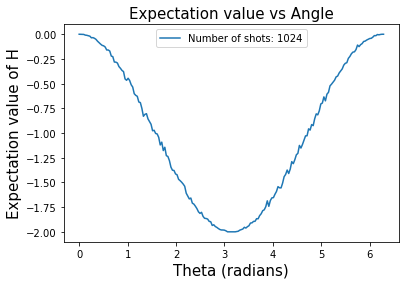

The minimum bound on the lowest eigenvalue of M is E0=-2.0,

The parameter that corresponds to this energy is theta=3.13 Rads


In [7]:
# Now we generate several thetas, and find the best set of parameters

import matplotlib.pyplot as plt

# The number of trials to run
N_shots = 2**10

# Generate theta grid
theta = np.linspace(0.0,2*np.pi,200)
E = np.zeros(len(theta))

# Calculate the expectation value of the Hamiltonian for different theta
for k in range(len(theta)):
    E[k] =  hamiltonian(theta=theta[k],N_shots=N_shots)
    

# Plot the results
plt.title('Expectation value vs Angle',fontsize=15)
plt.ylabel('Expectation value of H',fontsize=15)
plt.xlabel('Theta (radians)',fontsize=15)
plt.plot(theta,E,label='Number of shots: {}'.format(N_shots))
plt.legend()
plt.show()
    

# Determine the lowest bound from varying theta
print('='*100)
print('The minimum bound on the lowest eigenvalue of M is E0={},\n'.format(min(E)))
print('The parameter that corresponds to this energy is theta={:0.2f} Rads'.format(theta[np.argmin(E)]))
print('='*100)

Now that we have found the lower bound for the smallest eigenvalue of $M$, let us calculate the 
minimum eigenvalue directly to check our solution

In [8]:
w, v = np.linalg.eig(M)

print('='*100)
print('Minimum eigenvalue using classical computer: Lambda={:0.2f}'.format(min(w)))
print('The minimum bound of the Eigenvalue from the quantum computing simulations is E={:0.2f}'.format(min(E)))
print('='*100)

Minimum eigenvalue using classical computer: Lambda=-2.00
The minimum bound of the Eigenvalue from the quantum computing simulations is E=-2.00


Indeed, we see that the lower bound from the quantum circuit coincides with the lowest eigen value of the matrix.